# Distracted Driver Detection

Attempting to finetune Vgg16 model to solve https://www.kaggle.com/c/state-farm-distracted-driver-detection.

In [34]:
from importlib import reload
from keras.preprocessing import image

import os.path
import pandas as pd
import random
import sys

sys.path.insert(0, './../..')
import utils; reload(utils)
from utils import *

%matplotlib inline

K.set_image_dim_ordering('th')
base_dir = '../sample/'
# base_dir = '../'
batch_size = 64
output_size = 10
dropout = 0.7

In [4]:
gen = image.ImageDataGenerator()
gen_with_aug = image.ImageDataGenerator(rotation_range=15, 
                                        height_shift_range=0.05, 
                                        shear_range=0.1, 
                                        channel_shift_range=20, 
                                        width_shift_range=0.1)

batches = gen.flow_from_directory(base_dir + 'train/', 
                                  target_size=(224,224),
                                  class_mode='categorical', 
                                  shuffle=False, 
                                  batch_size=batch_size)
batches_aug = gen_with_aug.flow_from_directory(base_dir + 'train/', 
                                                   target_size=(224,224),
                                                   class_mode='categorical', 
                                                   shuffle=True, 
                                                   batch_size=batch_size)
val_batches = gen.flow_from_directory(base_dir + 'valid/',
                                     target_size=(224,224),
                                     class_mode='categorical',
                                     shuffle=False,
                                     batch_size=batch_size)
test_batches = gen.flow_from_directory(base_dir + 'test/',
                                     target_size=(224,224),
                                     class_mode='categorical',
                                     shuffle=False,
                                     batch_size=batch_size)

# Fragmented test batches for pseudo labeling
# test_batches_arr = []
# for i in range(4):
#     b = gen.flow_from_directory(base_dir + 'test' + str(i+1) + '/',
#                                      target_size=(224,224),
#                                      class_mode='categorical',
#                                      shuffle=False,
#                                      batch_size=batch_size)
#     test_batches_arr.append(b)

trn_labels = to_categorical(batches.classes)
val_labels = to_categorical(val_batches.classes)

Found 1500 images belonging to 10 classes.
Found 1500 images belonging to 10 classes.
Found 1000 images belonging to 10 classes.
Found 0 images belonging to 1 classes.


In [ ]:
filenames = batches.filenames
labels = batches.classes

# View each category
for i in range(output_size):
    idx = np.random.permutation(np.where(labels == i)[0])[:4]
    plot([image.load_img(base_dir + 'train/' + filenames[j]) for j in idx], titles=[filenames[j] for j in idx])

In [ ]:
# View each driver
imgs_table = pd.read_csv('../driver_imgs_list.csv')
driver_id = random.sample(imgs_table['subject'].unique().tolist(), 1)
driver_imgs_table = imgs_table[imgs_table['subject'].isin(driver_id)]

img_paths = []
for index, row in driver_imgs_table.iterrows():
    filepath = base_dir + 'train/' + row['classname'] + '/' + row['img']
    if os.path.isfile(filepath): img_paths.append(filepath) # Some have been moved to validation
        
plot_paths(img_paths)

## Convolutional pre-computing

In [ ]:
m = vgg(output_size, dropout=dropout)
cm = conv_model(m)

batches.reset()
trn_features = cm.predict_generator(batches, steps(batches, batch_size), verbose=1)
save_array(base_dir + 'models/train_convlayer_features.bc', trn_features)

val_batches.reset()
val_features = cm.predict_generator(val_batches, steps(val_batches, batch_size), verbose=1)
save_array(base_dir + 'models/valid_convlayer_features.bc', val_features)

In [ ]:
for i in range(4):
    b = test_batches_arr[i]
    b.reset()
    features = cm.predict_generator(b, steps(b, batch_size), verbose=1)
    save_array(base_dir + 'models/test' + str(i + 1) + '_convlayer_features.bc', features)

In [5]:
trn_features = load_array(base_dir + 'models/train_convlayer_features.bc')
val_features = load_array(base_dir + 'models/valid_convlayer_features.bc')

## Finetuning

In [6]:
def finetune_last_layer(model, index):
    dm = vgg_fc_model(model, output_size, dropout=dropout)
    for i in range(len(dm.layers)): dm.layers[i].trainable = i >= len(dm.layers) - 3
    
    fit_with_features(dm, RMSprop(1e-5), 12, trn_features, trn_labels, val_features, val_labels, batch_size=batch_size)
    fit_with_features(dm, RMSprop(1e-7), 6, trn_features, trn_labels, val_features, val_labels, batch_size=batch_size)
    
    for l1,l2 in zip(model.layers[last_conv_idx(model) + 1:], dm.layers): l1.set_weights(l2.get_weights())
    model.save_weights(base_dir + 'models/last' + str(index) + '.h5')
    
def finetune_dense_layers(model, index):
    dm = vgg_fc_model(model, output_size, dropout=dropout)
    for l in dm.layers: l.trainable = True
    
    fit_with_features(dm, RMSprop(1e-5), 10, trn_features, trn_labels, val_features, val_labels, batch_size=batch_size)
    fit_with_features(dm, RMSprop(1e-6), 8, trn_features, trn_labels, val_features, val_labels, batch_size=batch_size)
    fit_with_features(dm, RMSprop(1e-7), 10, trn_features, trn_labels, val_features, val_labels, batch_size=batch_size)  
    
    for l1,l2 in zip(model.layers[last_conv_idx(model) + 1:], dm.layers): l1.set_weights(l2.get_weights())
    model.save_weights(base_dir + 'models/dense' + str(index) + '.h5')
    
def finetune_w_valid_pseudo_labels(model, index):
    finetune_w_pseudo_labels(model, index, val_features, "pseudo_label")  
    
def finetune_w_test_pseudo_labels(model, index):
    for i in range(4):
        features = load_array(base_dir + 'models/test' + str(i+1) + '_convlayer_features.bc')
        finetune_w_pseudo_labels(model, index, features, "pseudo_label_w_test")
        
def finetune_w_pseudo_labels(model, index, features, log_id):
    dm = vgg_fc_model(model, output_size, dropout=dropout)
    for l in dm.layers: l.trainable = True
        
    pseudo_labels = dm.predict(features, batch_size=batch_size, verbose=1)
    comb_labels = np.concatenate([trn_labels, pseudo_labels])
    comb_features = np.concatenate([trn_features, features])

    fit_with_features(dm, RMSprop(1e-5), 6, comb_features, comb_labels, val_features, val_labels, batch_size=batch_size)
    fit_with_features(dm, RMSprop(1e-6), 8, comb_features, comb_labels, val_features, val_labels, batch_size=batch_size)
    fit_with_features(dm, RMSprop(1e-7), 10, comb_features, comb_labels, val_features, val_labels, batch_size=batch_size)

    for l1,l2 in zip(model.layers[last_conv_idx(model) + 1:], dm.layers): l1.set_weights(l2.get_weights())
    model.save_weights(base_dir + 'models/' + log_id + str(index) + '.h5')
    
def finetune_dense_layers_with_aug(model, index):
    for i in range(len(model.layers)): model.layers[i].trainable = i >= 16
    fit_dense_layers_with_aug(model, index, RMSprop(1e-5), 8)
    fit_dense_layers_with_aug(model, index, RMSprop(1e-7), 10)
    fit_with_batches(model, RMSprop(1e-5), 8, batches_aug, val_batches, batch_size=batch_size)
    fit_with_batches(model, RMSprop(1e-7), 10, batches_aug, val_batches, batch_size=batch_size)
    model.save_weights(base_dir + 'models/dense_pseudo_aug' + str(index) + '.h5')

## Training

In [7]:
clear_logs()
model = vgg(output_size, dropout=dropout)
finetune_last_layer(model, 0)
finetune_dense_layers(model, 0)
# finetune_w_valid_pseudo_labels(model, 0)
# finetune_w_test_pseudo_labels(model, 0)
# finetune_dense_layers_with_aug(model, 0)
log_action("Finished training model")

Train on 1500 samples, validate on 1000 samples
Epoch 1/12
1500/1500 [==============================] - 1s - loss: 7.5894 - acc: 0.1047 - val_loss: 3.8299 - val_acc: 0.1230
Epoch 2/12
1500/1500 [==============================] - 1s - loss: 7.6912 - acc: 0.1020 - val_loss: 3.6419 - val_acc: 0.1280
Epoch 3/12
1500/1500 [==============================] - 1s - loss: 7.6177 - acc: 0.1007 - val_loss: 3.5001 - val_acc: 0.1290
Epoch 4/12
1500/1500 [==============================] - 1s - loss: 7.6614 - acc: 0.0967 - val_loss: 3.4088 - val_acc: 0.1250
Epoch 5/12
1500/1500 [==============================] - 1s - loss: 7.6807 - acc: 0.1113 - val_loss: 3.3486 - val_acc: 0.1240
Epoch 6/12
1500/1500 [==============================] - 1s - loss: 7.4595 - acc: 0.1080 - val_loss: 3.3090 - val_acc: 0.1310
Epoch 7/12
1500/1500 [==============================] - 1s - loss: 7.4788 - acc: 0.1027 - val_loss: 3.2945 - val_acc: 0.1300
Epoch 8/12
1500/1500 [==============================] - 1s - loss: 7.7507 - a

In [ ]:
model = vgg(output_size, dropout=dropout)
model.load_weights(base_dir + 'models/pseudo_label0.h5')

## Visualization

16/16 [==============================] - 23s    
[[85  8  0  5 10  0  0  4  0  8]
 [ 0 70  0  0  2  1  6 14  2  1]
 [ 0  1 64  0  2  0  4  8  5  1]
 [ 3  0  0 93  6  0  0  3  0  3]
 [ 1  0  0  7 77  0  0  0  0  2]
 [ 6  1  0  1 14 77  0  3  0  6]
 [ 0 26  7  3  4  0 56 14  7  0]
 [ 0  0  0  3  2  3  5 81  1  0]
 [ 0  8  4  0 14  4 25 26 18  3]
 [17  5  0 13 17  1  2  9  0 18]]


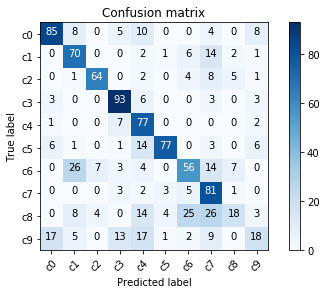

In [47]:
filenames = val_batches.filenames
labels = val_batches.classes

val_batches.reset()
probs = model.predict_generator(val_batches, steps(val_batches, batch_size), verbose=1)
predicted_labels = probs.argmax(axis=1)

from sklearn.metrics import confusion_matrix
cm = confusion_matrix(labels, predicted_labels)

plot_confusion_matrix(cm, val_batches.class_indices)

## Submit to Kaggle

In [ ]:
def do_clip(arr, mx): return np.clip(arr, (1-mx)/9, mx)

preds = model.predict_generator(test_batches, steps(test_batches, batch_size), verbose=1)
clipped_preds = do_clip(preds, 0.93)

classes = sorted(batches.class_indices, key=batches.class_indices.get)
submission = pd.DataFrame(clipped_preds, columns=classes)
submission.insert(0, 'img', [a[8:] for a in test_batches.filenames])
file_path = base_dir + 'submission.gz'
submission.to_csv(file_path, index=False, compression='gzip')
    
from IPython.display import FileLink
FileLink(file_path)

## Not tried

- Other architecture
- Ensembling